# DEM from AIA Data

Invert AIA data to get EM distribution and EM slope map

Do this for two different cases:

- AIA FOV
- EIS FOV

Save an EM slope map for each FOV and each AR. In each case, we'll pick the time that most closely corresponds to the EIS raster

In [1]:
import asdf
import astropy.table
import astropy.units as u
import eispac.core
import matplotlib.pyplot as plt
import ndcube
import numpy as np
import pathlib
import sunpy.map

from astropy.visualization import ImageNormalize, LogStretch
from astropy.nddata import StdDevUncertainty
from astropy.wcs import WCS
from ndcube.wcs.tools import unwrap_wcs_to_fitswcs

from sunkit_dem import Model
from synthesizAR.analysis import make_slope_map, log_log_linear_fit
from synthesizAR.instruments.sdo import _TEMPERATURE_RESPONSE as aia_temperature_response
from synthesizAR.instruments.util import read_cube_from_dataset, write_cube_to_netcdf

import sys
sys.path.append('../scripts')
from dem import HK12Model

/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
root_dir = pathlib.Path('../../../talks/loops-workshop-2024-talk/data/')

In [7]:
ar_table = astropy.table.QTable.read(root_dir / 'tables' / 'mason_ars_region_1.asdf')

In [8]:
channel_list = ['94','131','171','193','211','335']

Build response kernels

In [9]:
kernels = {f'aia_{channel}': aia_temperature_response[channel] for channel in channel_list}
kernel_temperature = aia_temperature_response['temperature']

Build collections of maps at the observation midpoint

In [14]:
def build_aia_collection(top_dir, ref_date, error_percentage=0.1):
    top_dir = pathlib.Path(top_dir)
    collection = []
    for channel in ['94','131','171','193','211','335']:
        file_list = sorted(top_dir.glob(f'aia.lev2*.{channel}.image.fits'))
        maps = sunpy.map.Map(file_list)
        dates = astropy.time.Time([m.meta['t_obs'] for m in maps])
        i_ref = np.argmin(np.fabs((dates - ref_date).to_value('s')))
        #print(i_ref)
        m_aia = maps[i_ref]
        m_aia.mask = np.isnan(m_aia.data)
        data = np.where(m_aia.data<0,0,m_aia.data)
        collection.append((f'aia_{channel}', ndcube.NDCube(data,
                                                           wcs=m_aia.wcs,
                                                           meta=m_aia.meta,
                                                           unit=m_aia.unit/u.pix,
                                                           mask=m_aia.mask,
                                                           uncertainty=error_percentage*data,)))
    return ndcube.NDCollection(collection, aligned_axes=(0,1))


#def build_aia_collection_from_cube(filename, error_percentage=0.1):
#    ds = xarray.open_dataset(filename, engine='zarr', chunks={})
#    collection = []
#    for channel in ['94','131','171','193','211','335']:
#        data = ds[channel].data.mean(axis=0).compute()
#        mask = np.isnan(data).any(axis=0)
#        meta = ds[channel].attrs
#        unit = u.Unit(meta.pop('unit'))
#        wcs = WCS(header=meta)
#        collection.append((f'aia_{channel}', ndcube.NDCube(data,
#                                                           wcs=wcs,
#                                                           meta=meta,
#                                                           unit=unit/u.pix,
#                                                           mask=mask,
#                                                           uncertainty=error_percentage*data,)))
#    return ndcube.NDCollection(collection, aligned_axes=(0,1))

In [15]:
delta_log_t = 0.1
temperature_bin_edges = 10**np.arange(5.0, 7.2+delta_log_t, delta_log_t) * u.K

In [16]:
dem_settings = {
    'alpha': 1.25,
    'increase_alpha': 1.5,
    'max_iterations': 100,
    'use_em_loci': False,
    'emd_int': False,
    'l_emd': False,
    'guess': 1,
}

In [17]:
for row in ar_table:
    print(row['NOAA AR'])
    top_dir = root_dir / f'noaa_{row["NOAA AR"]}'
    em_dir = top_dir / 'diagnostics' / 'dem'
    em_dir.mkdir(exist_ok=True, parents=True)
    for l2_dir in ['level_2', 'level_2_EIS']:
        print(l2_dir)
        _collection = build_aia_collection(top_dir / 'AIA' / l2_dir, row['Date mid'])
        #_collection = build_aia_collection_from_cube(top_dir / 'AIA' / f'{l2_dir}_datacubes.zarr')
        dem_model = Model(_collection,
                          kernels,
                          temperature_bin_edges,
                          kernel_temperatures=kernel_temperature,
                          model='hk12')
        dem_res = dem_model.fit(**dem_settings)
        dem_res['em'].mask = dem_res['dem'].mask
        fov_label = f'fov{"EIS" if l2_dir=='level_2_EIS' else "AIA"}'
        write_cube_to_netcdf(em_dir / f'em_noaa{row["NOAA AR"]}_{fov_label}.nc',
                            'temperature',
                             dem_res['em'])

11944
level_2


2024-12-09 01:20:53 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:20:54 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:20:56 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:20:57 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:20:59 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:21:01 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


  0%|                                                                                                                  | 0.00/6.34k [00:00<?, ? x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
  0%|                                                                                                           | 3.00/6.34k [00:00<03:48, 27.7 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divid

level_2_EIS


2024-12-09 01:23:26 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:23:29 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:23:31 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:23:34 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:23:37 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:23:39 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 614/614 [00:09<00:00, 62.3 x10^2 DEM/s]


11967
level_2


2024-12-09 01:23:52 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:23:54 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:23:56 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:23:58 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:24:00 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:24:02 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


  0%|                                                                                                           | 1.00/5.98k [00:00<51:46, 1.93 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
  0%|▏                                                                                                          | 11.0/5.98k [00:00<05:15, 18.9 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divid

level_2_EIS


2024-12-09 01:26:09 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:26:11 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:26:13 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:26:15 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:26:17 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:26:18 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


 32%|███████████████████████████████████▎                                                                          | 197/614 [00:02<00:05, 73.5 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
 35%|██████████████████████████████████████▋                                                                       | 216/614 [00:03<00:05, 72.0 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divid

11990
level_2


2024-12-09 01:26:29 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:26:31 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:26:33 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:26:35 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:26:36 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:26:38 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


  5%|█████▌                                                                                                      | 286/5.56k [00:05<01:35, 55.4 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
  6%|██████▋                                                                                                     | 346/5.56k [00:06<01:30, 57.5 x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/agu-2024-poster/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divid

level_2_EIS


2024-12-09 01:28:34 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:28:37 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:28:41 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:28:44 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:28:47 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


2024-12-09 01:28:50 - astropy - INFO: uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 44.0 x10^2 DEM/s]


Now try to fit the EM slopes

In [45]:
slope_fitting_params = {
    'temperature_bounds': (0.9*u.MK,3*u.MK),
    'em_threshold': 1e24*u.cm**(-5),
    'rsquared_tolerance': 0.7,
    'iterate_bounds':False,
    'max_upper_bound': 8*u.MK,
    'mask_negative': True,
}

In [46]:
for row in ar_table:
    top_dir = root_dir / f'noaa_{row["NOAA AR"]}'
    em_dir = top_dir / 'diagnostics' / 'dem'
    for l2_dir in ['level_2', 'level_2_EIS']:
        fov_label = f'fov{"EIS" if l2_dir=='level_2_EIS' else "AIA"}'
        dem_res = read_cube_from_dataset(em_dir / f'em_noaa{row["NOAA AR"]}_{fov_label}.nc',
                                        'temperature',
                                        'phys.temperature')
        slope_map = make_slope_map(dem_res, **slope_fitting_params)
        with asdf.AsdfFile({'slope_map': slope_map}) as asdf_file:
            asdf_file.write_to(em_dir / f'emslope_noaa{row["NOAA AR"]}_{fov_label}.asdf')

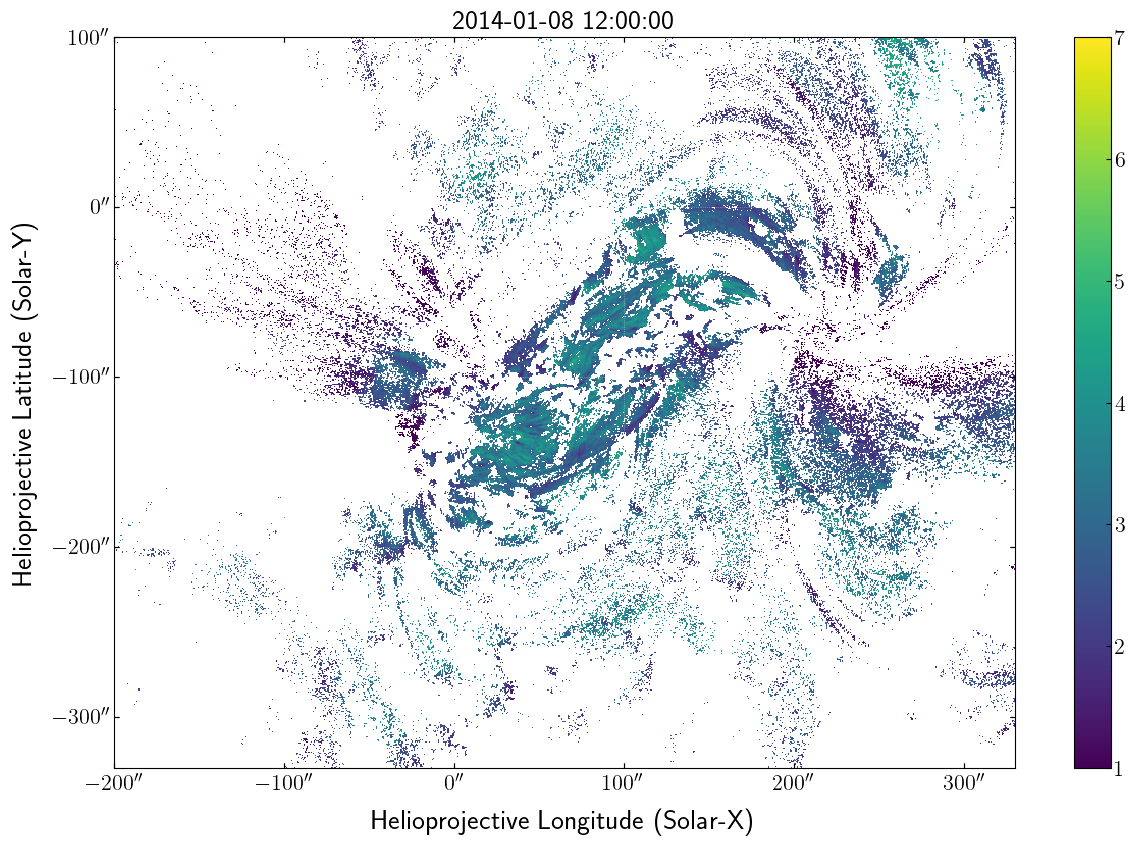

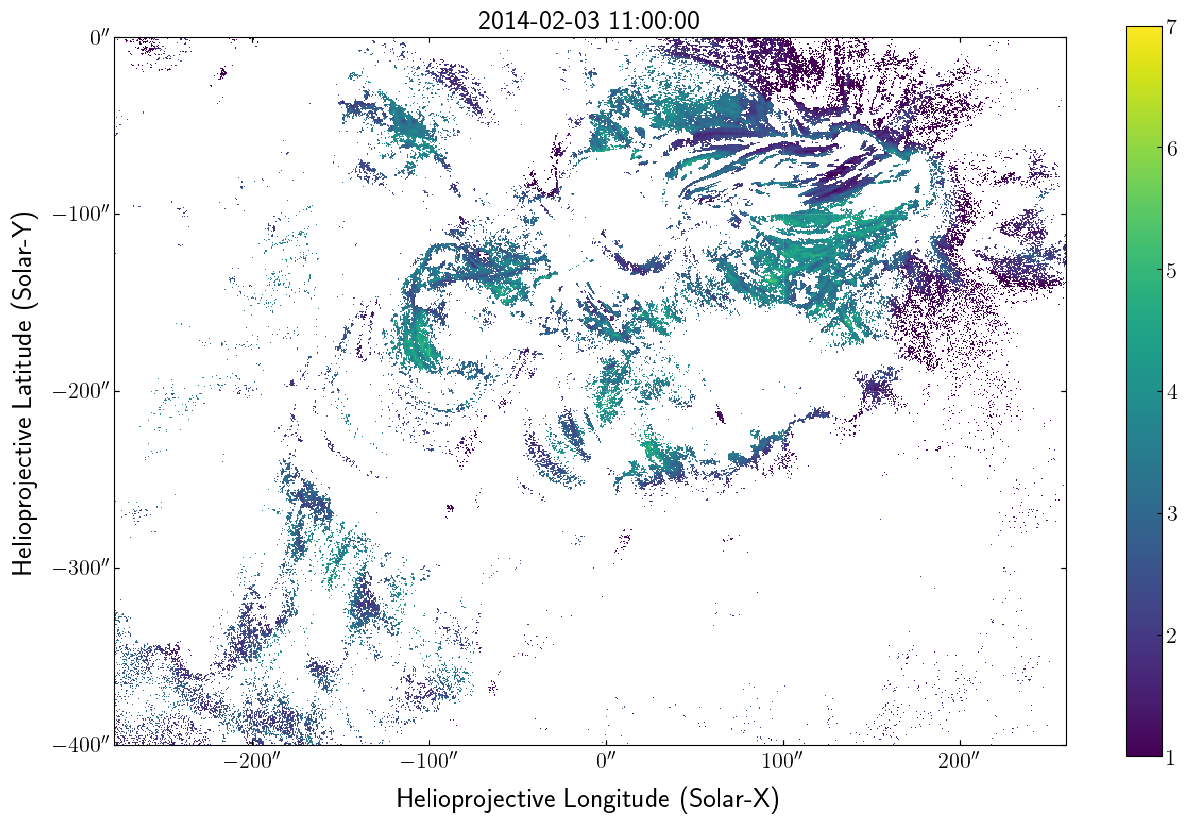

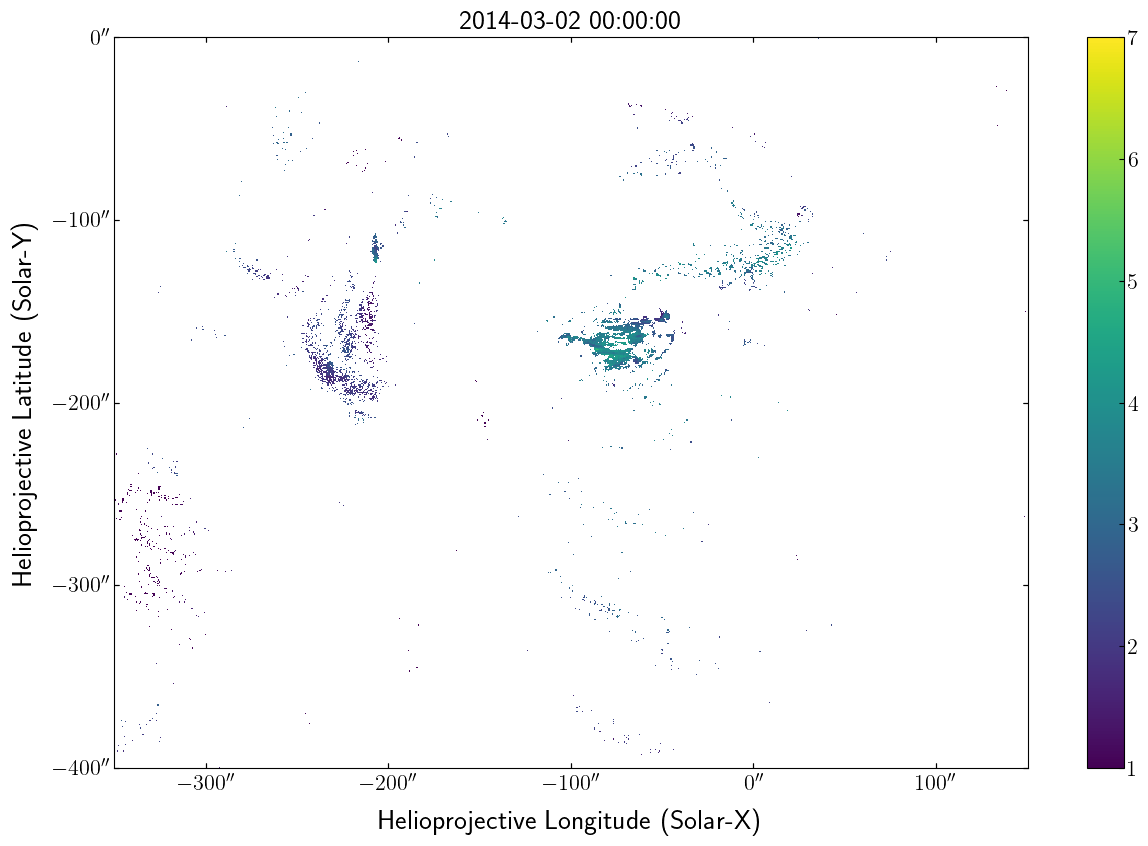

In [42]:
for row in ar_table:
    with asdf.open(root_dir / f'noaa_{row["NOAA AR"]}/diagnostics/dem/emslope_noaa{row["NOAA AR"]}_fovAIA.asdf', lazy_load=False) as af:
        _sm = af['slope_map']
    _sm.peek(vmin=1,vmax=7, cmap='viridis', aspect=_sm.scale[1]/_sm.scale[0])

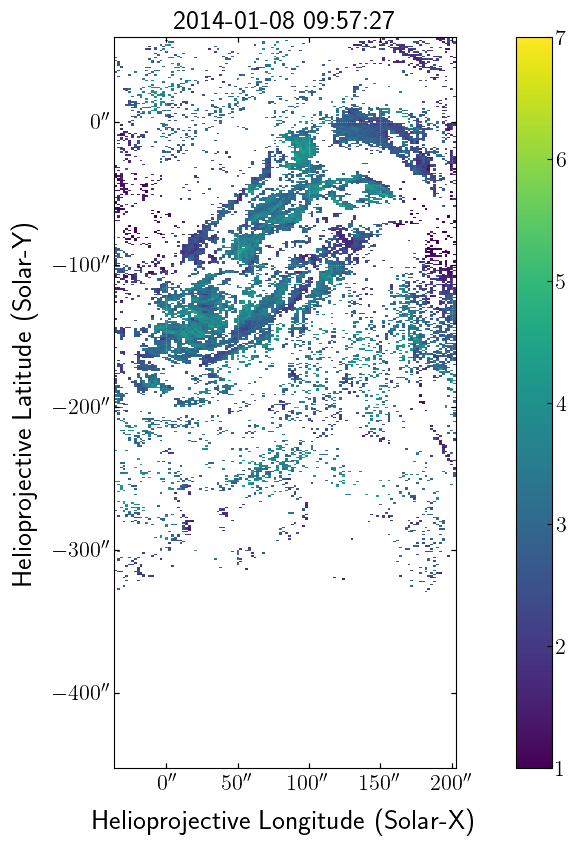

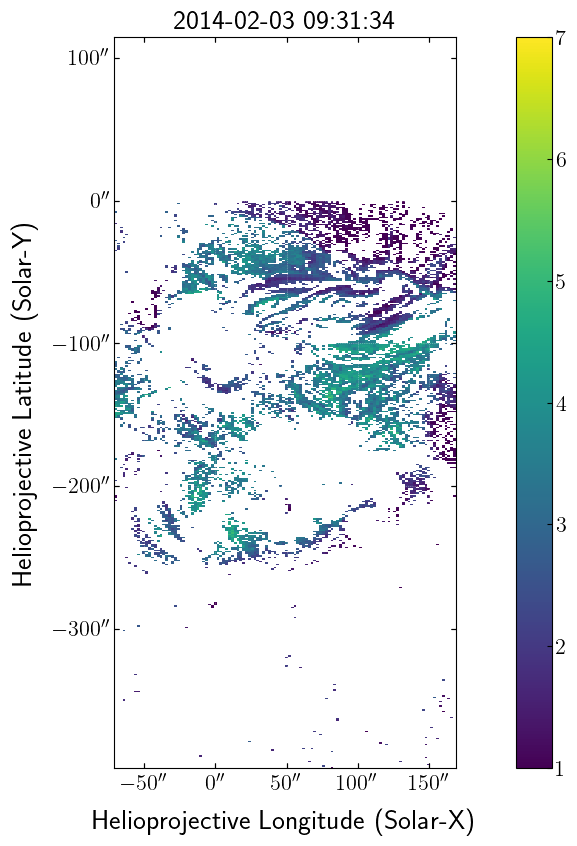

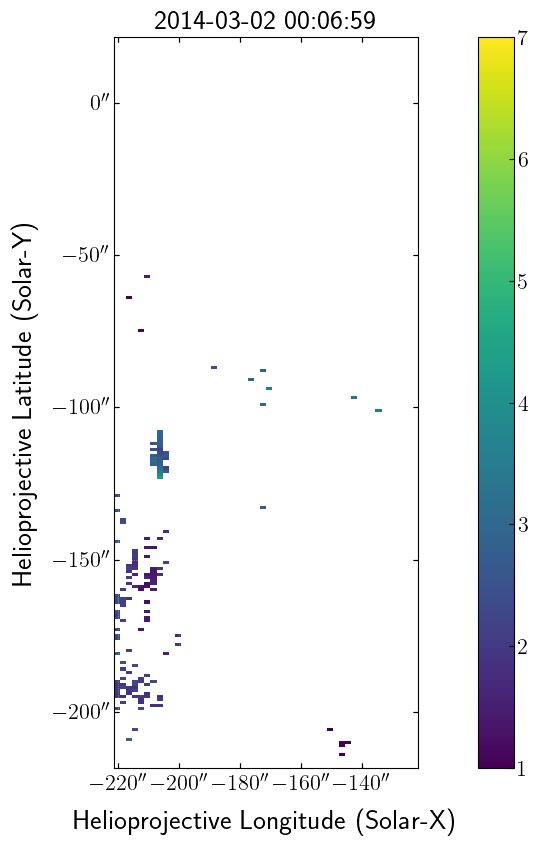

In [43]:
for row in ar_table:
    with asdf.open(root_dir / f'noaa_{row["NOAA AR"]}/diagnostics/dem/emslope_noaa{row["NOAA AR"]}_fovEIS.asdf', lazy_load=False) as af:
        _sm = af['slope_map']
    _sm.peek(vmin=1,vmax=7, cmap='viridis', aspect=_sm.scale[1]/_sm.scale[0])

(0.0, 7.5)

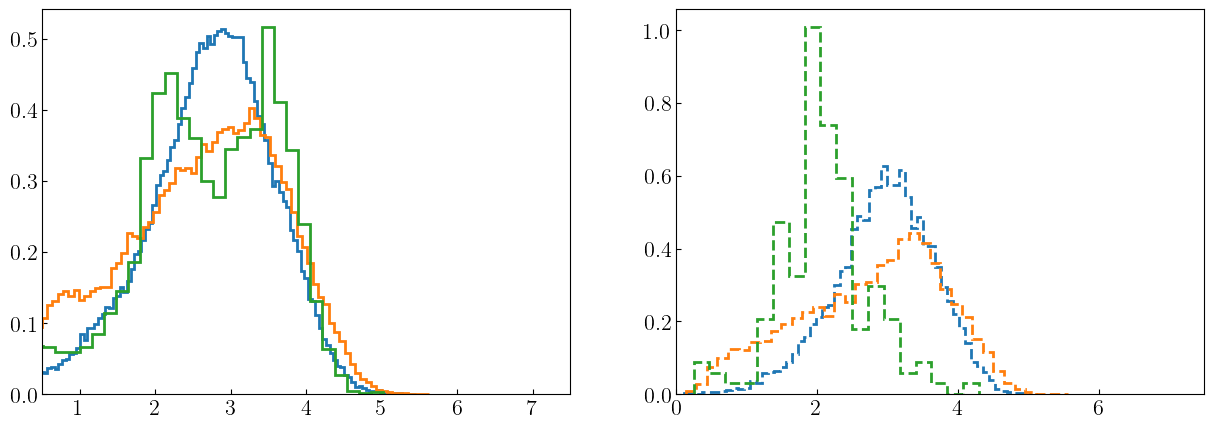

In [44]:
plt.figure(figsize=(15,5))
plt.subplot(121)
for i,row in enumerate(ar_table):
    with asdf.open(root_dir / f'noaa_{row["NOAA AR"]}/diagnostics/dem/emslope_noaa{row["NOAA AR"]}_fovAIA.asdf', lazy_load=False) as af:
        _sm = af['slope_map']
    plt.hist(_sm.data[~_sm.mask], histtype='step', bins='fd', density=True, color=f'C{i}');
plt.xlim(0.5,7.5)
plt.subplot(122)
for i,row in enumerate(ar_table):
    with asdf.open(root_dir / f'noaa_{row["NOAA AR"]}/diagnostics/dem/emslope_noaa{row["NOAA AR"]}_fovEIS.asdf', lazy_load=False) as af:
        _sm = af['slope_map']
    plt.hist(_sm.data[~_sm.mask], histtype='step', bins='fd', density=True, ls='--', color=f'C{i}');
plt.xlim(0.0,7.5)

In [9]:
dem_res = read_cube_with_xarray('../data/noaa_11944/diagnostics/dem/em_noaa11944_fovAIA.nc',
                                'temperature',
                                'phys.temperature')

$$
\frac{T_B}{T_A} \ge \delta
$$

$$
\log{T_B} - \log{T_A} \ge \log{\delta}
$$

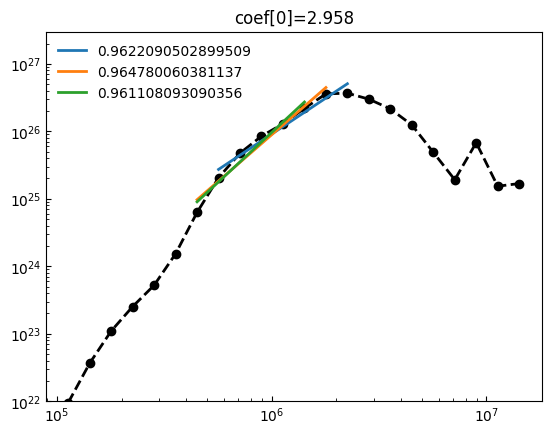

In [159]:
dem_selected = dem_res[:,580,230].data
temp_bin_centers = dem_res.axis_world_coords(0)[0]
tmax = temp_bin_centers.value[np.argmax(dem_selected)]
plt.plot(temp_bin_centers,dem_selected, color='k', marker='o', ls='--')
r2_vals = []
coefs = []
for i in range(10):
    T_b = temp_bin_centers.value[np.argmax(dem_selected)-i]  #max(tmax*fac,1e6),#temp_bin_centers.value[np.argmax(dem_selected)]
    T_a = max(T_b*0.2,4e5),
    if T_b/T_a < 3:
        break
    coef,x_fit,y_fit,r2 = log_log_linear_fit(temp_bin_centers.value,
                                             dem_selected,
                                             T_a,
                                             T_b,
                                            )
    plt.plot(10**x_fit, (10**coef[1])*(10**x_fit)**coef[0], label=r2)
    r2_vals.append(r2)
    coefs.append(coef[0])
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e22,3e27)
plt.title(f'{coef[0]=:.3f}')
plt.legend()

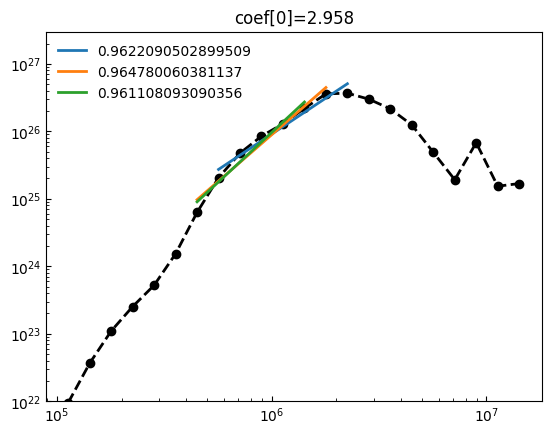

In [159]:
dem_selected = dem_res[:,580,230].data
temp_bin_centers = dem_res.axis_world_coords(0)[0]
tmax = temp_bin_centers.value[np.argmax(dem_selected)]
from synthesizAR.analysis import _iterate_fit_range
coef,r2 = 
#plt.plot(temp_bin_centers,dem_selected, color='k', marker='o', ls='--')
#r2_vals = []
#coefs = []
#for i in range(10):
#    T_b = temp_bin_centers.value[np.argmax(dem_selected)-i]  #max(tmax*fac,1e6),#temp_bin_centers.value[np.argmax(dem_selected)]
#    T_a = max(T_b*0.2,4e5),
#    if T_b/T_a < 3:
#        break
#    coef,x_fit,y_fit,r2 = log_log_linear_fit(temp_bin_centers.value,
#                                             dem_selected,
#                                             T_a,
#                                             T_b,
#                                            )
#    plt.plot(10**x_fit, (10**coef[1])*(10**x_fit)**coef[0], label=r2)
#    r2_vals.append(r2)
#    coefs.append(coef[0])
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim(1e22,3e27)
#plt.title(f'{coef[0]=:.3f}')
#plt.legend()

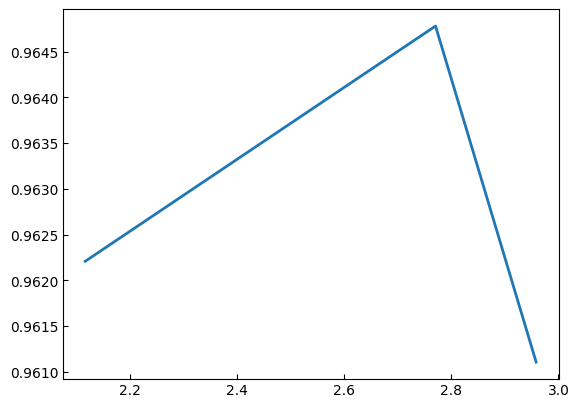

In [160]:
plt.plot(coefs, r2_vals)